In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
sns.set_style("whitegrid")
plt.style.use('default')

In [2]:
df = pd.read_csv(r"C:\Users\dipay\Downloads\final_food_delivery_dataset.csv")
df['total_amount'] = pd.to_numeric(df['total_amount'], errors='coerce')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['order_date'] = pd.to_datetime(df['order_date'], format='%d-%m-%Y', errors='coerce')

for col in ['city', 'membership', 'cuisine', 'restaurant_name', 'name']:
    if col in df.columns:
        df[col] = df[col].astype('string')

print(f"Dataset shape: {df.shape}")
display(df.head())

Dataset shape: (10000, 12)


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name,name,city,membership,restaurant_name_restaurant,cuisine,rating
0,1,2508,450,2023-02-18,842.97,New Foods Chinese,User_2508,Hyderabad,Regular,Restaurant_450,Mexican,3.2
1,2,2693,309,2023-01-18,546.68,Ruchi Curry House Multicuisine,User_2693,Pune,Regular,Restaurant_309,Indian,4.5
2,3,2084,107,2023-07-15,163.93,Spice Kitchen Punjabi,User_2084,Chennai,Gold,Restaurant_107,Mexican,4.0
3,4,319,224,2023-10-04,1155.97,Darbar Kitchen Non-Veg,User_319,Bangalore,Gold,Restaurant_224,Chinese,4.8
4,5,1064,293,2023-12-25,1321.91,Royal Eatery South Indian,User_1064,Pune,Regular,Restaurant_293,Italian,3.0


In [3]:
overview = pd.DataFrame({
    'Metric': ['Total Orders', 'Distinct Users', 'Restaurants', 'Cities', 'Cuisines', 'Total Revenue', 'Avg Order Value'],
    'Value': [
        f"{len(df):,}",
        f"{df['user_id'].nunique():,}", 
        f"{df['restaurant_id'].nunique():,}",
        f"{df['city'].nunique()}",
        f"{df['cuisine'].nunique()}",
        f"₹{df['total_amount'].sum():,.0f}",
        f"₹{df['total_amount'].mean():.2f}"
    ]
})
display(overview)

missing = pd.DataFrame({
    'Column': df.columns,
    'Missing %': (df.isna().mean()*100).round(2)
}).sort_values('Missing %', ascending=False)
display(missing)

,Metric,Value
0,Total Orders,"10,000"
1,Distinct Users,"2,883"
2,Restaurants,500
3,Cities,4
4,Cuisines,4
5,Total Revenue,"₹8,011,624"
6,Avg Order Value,₹801.16


,Column,Missing %
order_id,order_id,0.0
user_id,user_id,0.0
restaurant_id,restaurant_id,0.0
order_date,order_date,0.0
total_amount,total_amount,0.0
restaurant_name,restaurant_name,0.0
name,name,0.0
city,city,0.0
membership,membership,0.0
restaurant_name_restaurant,restaurant_name_restaurant,0.0


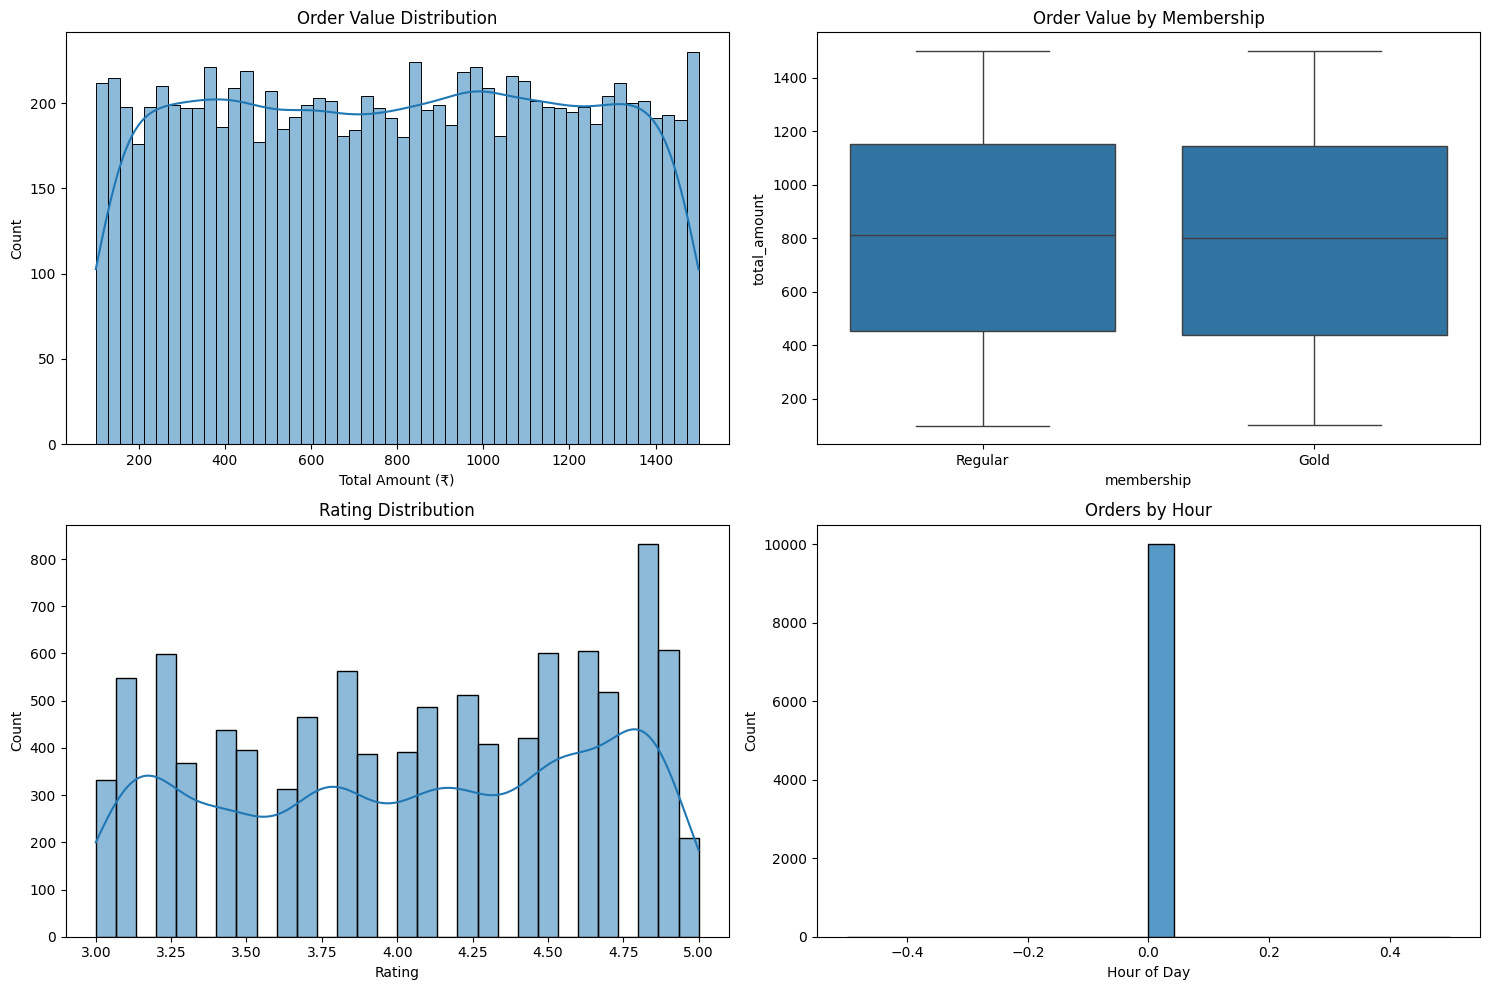

Numeric Summary:


,total_amount,rating
count,10000.00,10000.00
mean,801.16,4.05
std,405.46,0.61
min,100.20,3.00
25%,446.31,3.50
50%,806.30,4.10
75%,1149.23,4.60
max,1499.83,5.00


In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(df['total_amount'].dropna(), bins=50, kde=True, ax=axes[0,0])
axes[0,0].set_title('Order Value Distribution')
axes[0,0].set_xlabel('Total Amount (₹)')

sns.boxplot(data=df, x='membership', y='total_amount', ax=axes[0,1])
axes[0,1].set_title('Order Value by Membership')

sns.histplot(df['rating'].dropna(), bins=30, kde=True, ax=axes[1,0])
axes[1,0].set_title('Rating Distribution')
axes[1,0].set_xlabel('Rating')

df['order_hour'] = df['order_date'].dt.hour
sns.histplot(df['order_hour'].dropna(), bins=24, ax=axes[1,1])
axes[1,1].set_title('Orders by Hour')
axes[1,1].set_xlabel('Hour of Day')

plt.tight_layout()
plt.show()

print("Numeric Summary:")
display(df[['total_amount', 'rating']].describe().round(2))

In [5]:
print("\n1. GOLD MEMBERS REVENUE BY CITY")
gold_rev_city = df[df['membership']=='Gold'].groupby('city')['total_amount'].sum().round(0)
gold_rev_city = gold_rev_city.sort_values(ascending=False).astype(int)
print(gold_rev_city.to_string())

print("\n2. AVERAGE ORDER VALUE BY CUISINE") 
cuisine_aov = df.groupby('cuisine')['total_amount'].mean().round(2).sort_values(ascending=False)
print(cuisine_aov.to_string())

print("\n3. USERS BY TOTAL SPENDING (>₹1000)")
user_total = df.groupby('user_id')['total_amount'].sum().round(0)
high_value_users = (user_total > 1000).sum()
print(f"Users with >₹1000 total spend: {high_value_users:,}")
print(user_total.nlargest(10).astype(int).to_string())

print("\n4. REVENUE BY RATING RANGE")
df['rating_range'] = pd.cut(df['rating'], 
                           bins=[2.9, 3.5, 4.0, 4.5, 5.1], 
                           labels=['3.0–3.5', '3.6–4.0', '4.1–4.5', '4.6–5.0'],
                           right=False)
rating_rev = df.groupby('rating_range', observed=True)['total_amount'].sum().round(0)
print(rating_rev.astype(int).sort_values(ascending=False).to_string())

print("\n5. GOLD MEMBERS AVG ORDER BY CITY")
gold_city_aov = df[df['membership']=='Gold'].groupby('city')['total_amount'].mean().round(2)
print(gold_city_aov.sort_values(ascending=False).to_string())

print("\n6. CUISINE: RESTAURANTS vs REVENUE")
cuisine_stats = df.groupby('cuisine').agg({
    'restaurant_id': 'nunique',
    'total_amount': 'sum'
}).round(0)
cuisine_stats.columns = ['Restaurants', 'Revenue']
print(cuisine_stats.sort_values('Revenue', ascending=False).astype(int).to_string())


1. GOLD MEMBERS REVENUE BY CITY
city
Chennai      1080910
Pune         1003012
Bangalore     994703
Hyderabad     896740

2. AVERAGE ORDER VALUE BY CUISINE
cuisine
Mexican    808.02
Italian    799.45
Indian     798.47
Chinese    798.39

3. USERS BY TOTAL SPENDING (>₹1000)
Users with >₹1000 total spend: 2,544
user_id
1515    11556
650     10747
496      9634
2586     9487
2615     9237
636      9087
2973     9063
874      8917
1337     8908
2694     8876

4. REVENUE BY RATING RANGE
rating_range
4.6–5.0    2676078
3.0–3.5    1817951
4.1–4.5    1799541
3.6–4.0    1718055

5. GOLD MEMBERS AVG ORDER BY CITY
city
Chennai      808.46
Hyderabad    806.42
Bangalore    793.22
Pune         781.16

6. CUISINE: RESTAURANTS vs REVENUE
         Restaurants  Revenue
cuisine                      
Mexican          128  2085503
Italian          126  2024204
Indian           126  1971413
Chinese          120  1930505


In [6]:
print("\n7. MEMBERSHIP BREAKDOWN")
membership_stats = df['membership'].value_counts()
gold_pct = round((membership_stats['Gold'] / len(df)) * 100, 1)
print(membership_stats.to_string())
print(f"Gold percentage: {gold_pct}%")

print("\n8. SPECIFIC RESTAURANTS (<20 orders check)")
rest_avg = df.groupby('restaurant_id')['total_amount'].mean()
rest_count = df.groupby('restaurant_id').size()
specific_rests = ['Grand Cafe Punjabi', 'Grand Restaurant South Indian', 'Ruchi Mess Multicuisine', 'Ruchi Foods Chinese']
specific_details = []
for rest_name in specific_rests:
    matching = df[df['restaurant_name'].str.contains(rest_name, case=False, na=False)]
    if not matching.empty:
        rest_id = matching['restaurant_id'].iloc[0]
        avg_order = rest_avg.get(rest_id, 0)
        order_count = rest_count.get(rest_id, 0)
        specific_details.append({
            'Restaurant': rest_name,
            'Avg_Order': f"₹{avg_order:.2f}",
            'Order_Count': order_count,
            'Low_Volume': 'YES' if order_count < 20 else 'NO'
        })
    else:
        specific_details.append({'Restaurant': rest_name, 'Avg_Order': '-', 'Order_Count': 0, 'Low_Volume': '-'})
print(pd.DataFrame(specific_details).to_string(index=False))

print("\n9. SPECIFIC MEMBERSHIP + CUISINE COMBINATIONS")
specific_combos = [('Gold', 'Indian'), ('Gold', 'Italian'), ('Regular', 'Indian'), ('Regular', 'Chinese')]
combo_results = []
for membership, cuisine in specific_combos:
    revenue = df[(df['membership'] == membership) & (df['cuisine'] == cuisine)]['total_amount'].sum().round(0)
    combo_results.append({'Membership': membership, 'Cuisine': cuisine, 'Revenue': int(revenue)})
combo_df = pd.DataFrame(combo_results).sort_values('Revenue', ascending=False)
print(combo_df.to_string(index=False))
print(f"\n✓ HIGHEST: {combo_df.iloc[0]['Membership']} + {combo_df.iloc[0]['Cuisine']} (₹{combo_df.iloc[0]['Revenue']:,.0f})")

print("\n10. QUARTERLY REVENUE")
df['quarter'] = df['order_date'].dt.to_period('Q')
quarter_rev = df.groupby('quarter', observed=True)['total_amount'].sum().round(0)
print(quarter_rev.astype(int).sort_values(ascending=False).to_string())


7. MEMBERSHIP BREAKDOWN
membership
Regular    5013
Gold       4987
Gold percentage: 49.9%

8. SPECIFIC RESTAURANTS (<20 orders check)
                   Restaurant Avg_Order  Order_Count Low_Volume
           Grand Cafe Punjabi   ₹759.14           20         NO
Grand Restaurant South Indian   ₹842.57           29         NO
      Ruchi Mess Multicuisine   ₹938.20           18        YES
          Ruchi Foods Chinese   ₹686.60           19        YES

9. SPECIFIC MEMBERSHIP + CUISINE COMBINATIONS
Membership Cuisine  Revenue
      Gold Italian  1005779
   Regular  Indian   992100
      Gold  Indian   979312
   Regular Chinese   952791

✓ HIGHEST: Gold + Italian (₹1,005,779)

10. QUARTERLY REVENUE
quarter
2023Q3    2037385
2023Q4    2018264
2023Q1    1993425
2023Q2    1945349
2024Q1      17202
Freq: Q-DEC


In [7]:
print("\n1. TOTAL GOLD ORDERS:", f"{len(df[df['membership']=='Gold']):,}")
print("2. HYDERABAD REVENUE:", f"₹{df[df['city']=='Hyderabad']['total_amount'].sum().round(0):,}")
print("3. DISTINCT USERS:", f"{df['user_id'].nunique():,}")
print("4. GOLD AOV:", f"₹{df[df['membership']=='Gold']['total_amount'].mean().round(2)}")
print("5. ORDERS ≥4.5 RATING:", f"{len(df[df['rating']>=4.5]):,}")

gold_city_rev = df[df['membership']=='Gold'].groupby('city')['total_amount'].sum()
top_gold_city = gold_city_rev.idxmax()
top_gold_orders = len(df[(df['membership']=='Gold') & (df['city']==top_gold_city)])
print(f"6. TOP GOLD CITY: {top_gold_city} (₹{gold_city_rev.max():,.0f}, {top_gold_orders:,} orders)")


1. TOTAL GOLD ORDERS: 4,987
2. HYDERABAD REVENUE: ₹1,889,367.0
3. DISTINCT USERS: 2,883
4. GOLD AOV: ₹797.15
5. ORDERS ≥4.5 RATING: 3,374
6. TOP GOLD CITY: Chennai (₹1,080,910, 1,337 orders)


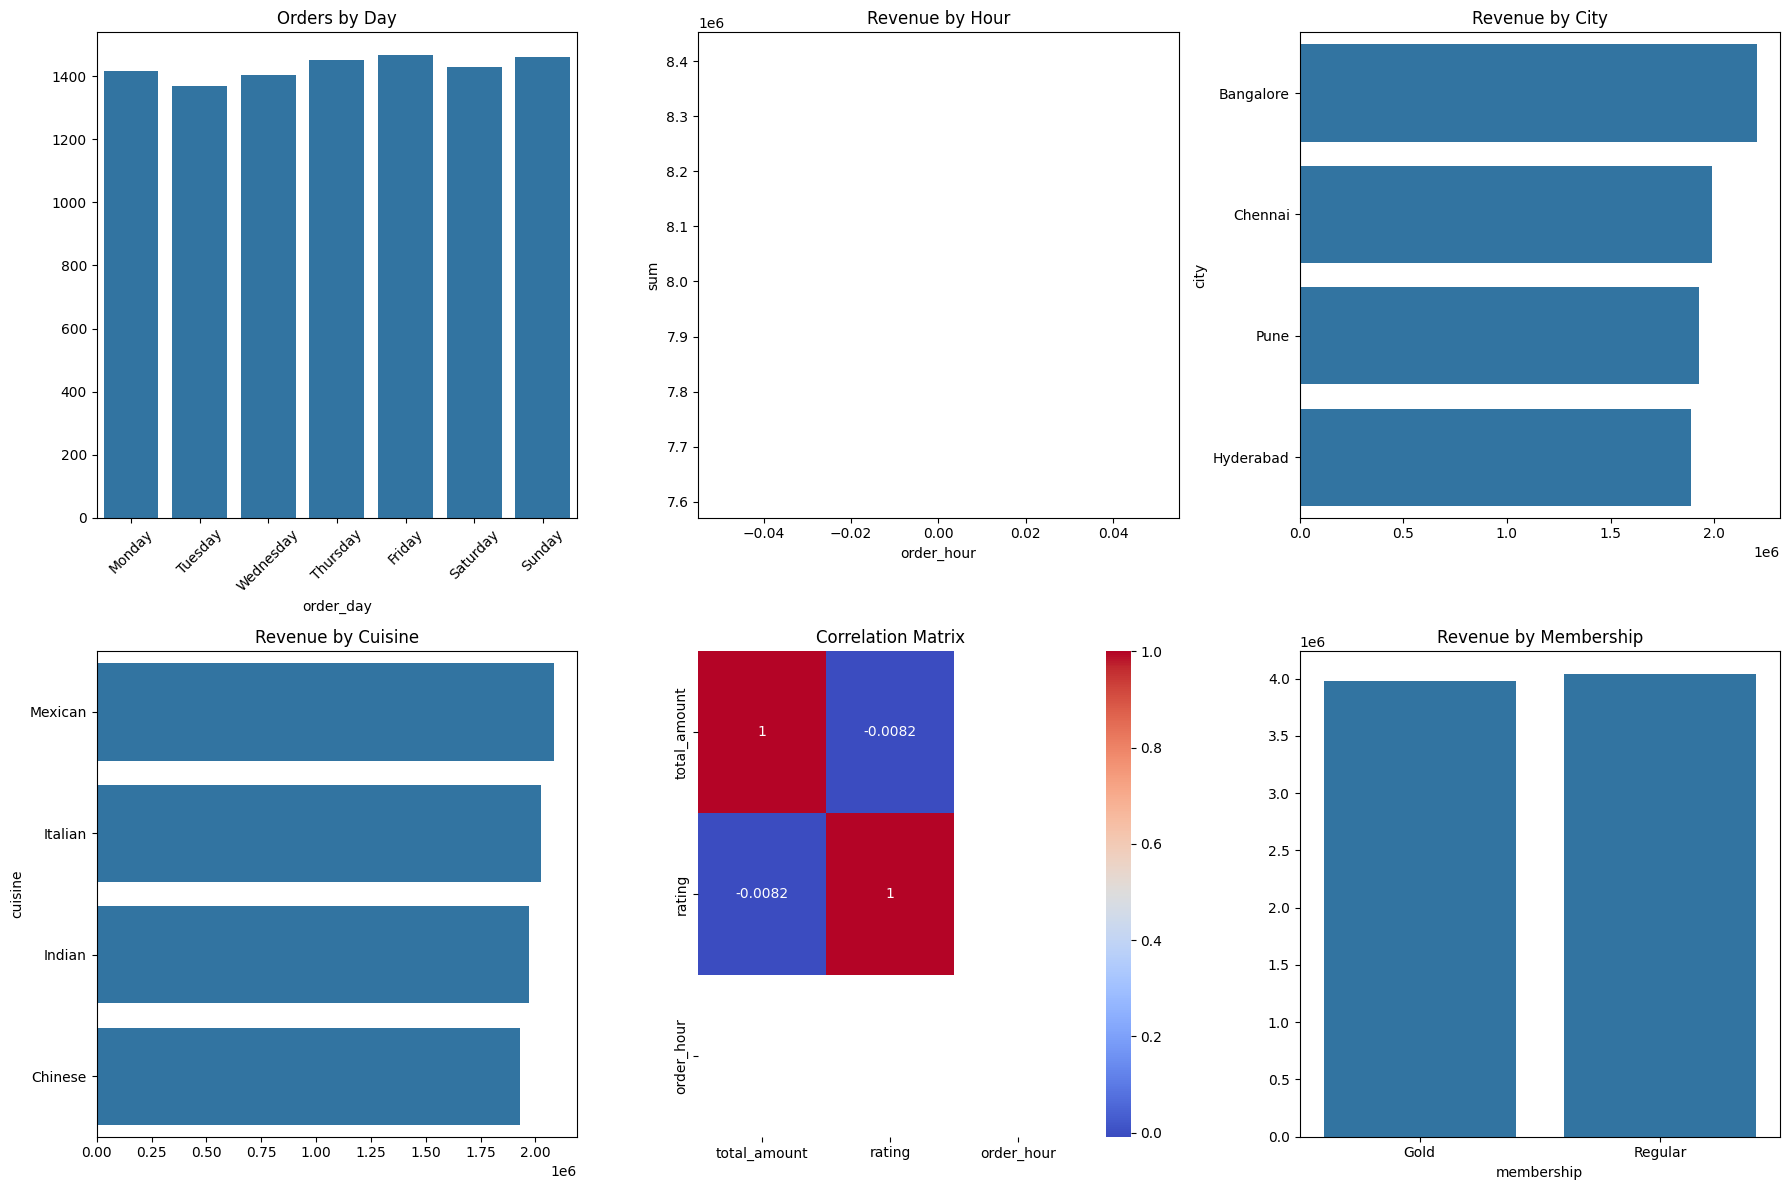

In [8]:
df['order_day'] = df['order_date'].dt.day_name()
df['order_month'] = df['order_date'].dt.month_name()
df['order_hour'] = df['order_date'].dt.hour

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

order_dist = df['order_day'].value_counts().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
sns.barplot(x=order_dist.index, y=order_dist.values, ax=axes[0,0])
axes[0,0].set_title('Orders by Day')
axes[0,0].tick_params(axis='x', rotation=45)

hourly = df.groupby('order_hour')['total_amount'].agg(['count','sum']).reset_index()
sns.lineplot(data=hourly, x='order_hour', y='sum', ax=axes[0,1])
axes[0,1].set_title('Revenue by Hour')

city_rev = df.groupby('city')['total_amount'].sum().sort_values(ascending=False)
sns.barplot(x=city_rev.values, y=city_rev.index, ax=axes[0,2])
axes[0,2].set_title('Revenue by City')

cuisine_rev = df.groupby('cuisine')['total_amount'].sum().sort_values(ascending=False)
sns.barplot(x=cuisine_rev.values, y=cuisine_rev.index, ax=axes[1,0])
axes[1,0].set_title('Revenue by Cuisine')

sns.heatmap(df[['total_amount', 'rating', 'order_hour']].corr(), annot=True, cmap='coolwarm', ax=axes[1,1])
axes[1,1].set_title('Correlation Matrix')

membership_rev = df.groupby('membership')['total_amount'].sum()
sns.barplot(x=membership_rev.index, y=membership_rev.values, ax=axes[1,2])
axes[1,2].set_title('Revenue by Membership')

plt.tight_layout()
plt.show()

USER BEHAVIOR SUMMARY
Top 10 users by spend:
         orders  total_spend  avg_order
user_id                                
1515         12        11556     963.04
650          10        10747    1074.74
496          11         9634     875.85
2586         10         9486     948.66
2615          9         9237    1026.37
636           9         9087    1009.68
2973         13         9063     697.16
874          11         8916     810.60
1337         11         8907     809.77
2694          8         8875    1109.46


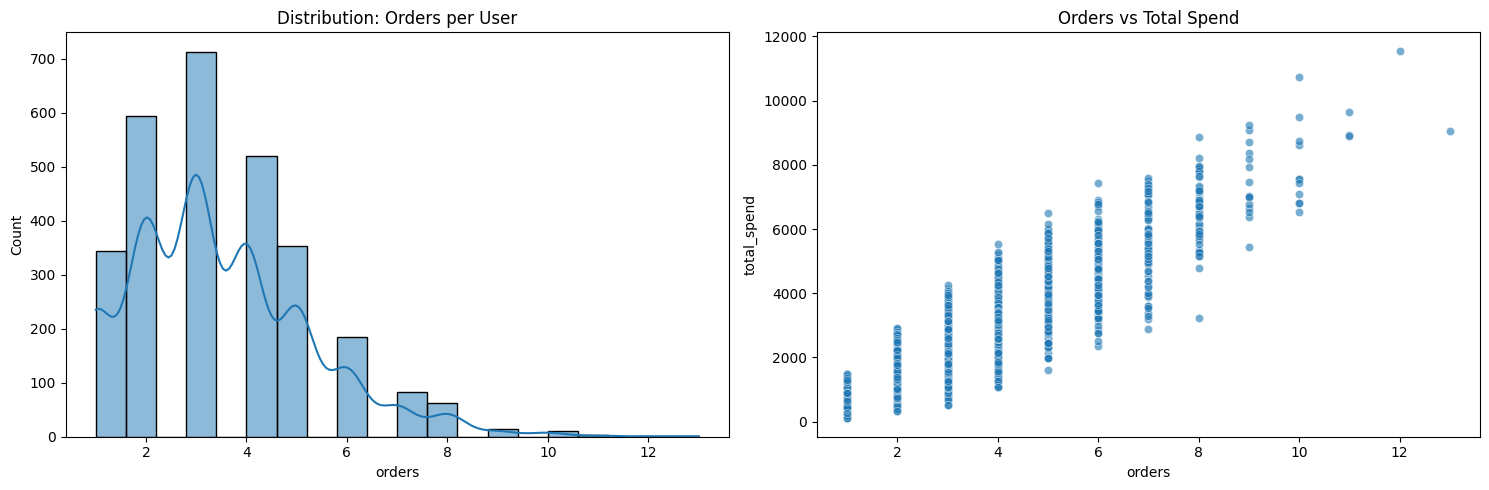

In [9]:
user_stats = df.groupby('user_id').agg({
    'total_amount': ['count', 'sum', 'mean'],
    'rating': 'mean',
    'restaurant_id': 'nunique'
}).round(2)

user_stats.columns = ['orders', 'total_spend', 'avg_order', 'avg_rating', 'restaurants_tried']
user_stats['high_value'] = (user_stats['total_spend'] > 1000).astype(int)

print("USER BEHAVIOR SUMMARY")
print(f"Top 10 users by spend:\n{user_stats.nlargest(10, 'total_spend')[['orders', 'total_spend', 'avg_order']].astype({'total_spend': 'int'}).to_string()}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(user_stats['orders'], bins=20, kde=True, ax=ax1)
ax1.set_title('Distribution: Orders per User')

sns.scatterplot(data=user_stats, x='orders', y='total_spend', alpha=0.6, ax=ax2)
ax2.set_title('Orders vs Total Spend')

plt.tight_layout()
plt.show()

TOP 10 LOW-VOLUME, HIGH-AOV RESTAURANTS
            restaurant_name  orders     aov  revenue
   Hotel Dhaba Multicuisine      13 1040.22  13523.0
         Hotel Cafe Punjabi      18 1029.47  18531.0
           Sri Mess Punjabi      12 1029.18  12350.0
Swagath Eatery Multicuisine      15 1026.31  15395.0
      Ruchi Biryani Punjabi      16 1002.14  16034.0
       Swagath Foods Andhra      15  989.82  14847.0
      Sri Delights Pure Veg      18  989.47  17810.0
        Amma Eatery Non-Veg      18  988.70  17797.0
            Sai Cafe Andhra      17  986.03  16762.0
  Udupi Curry House Chinese      14  982.73  13758.0


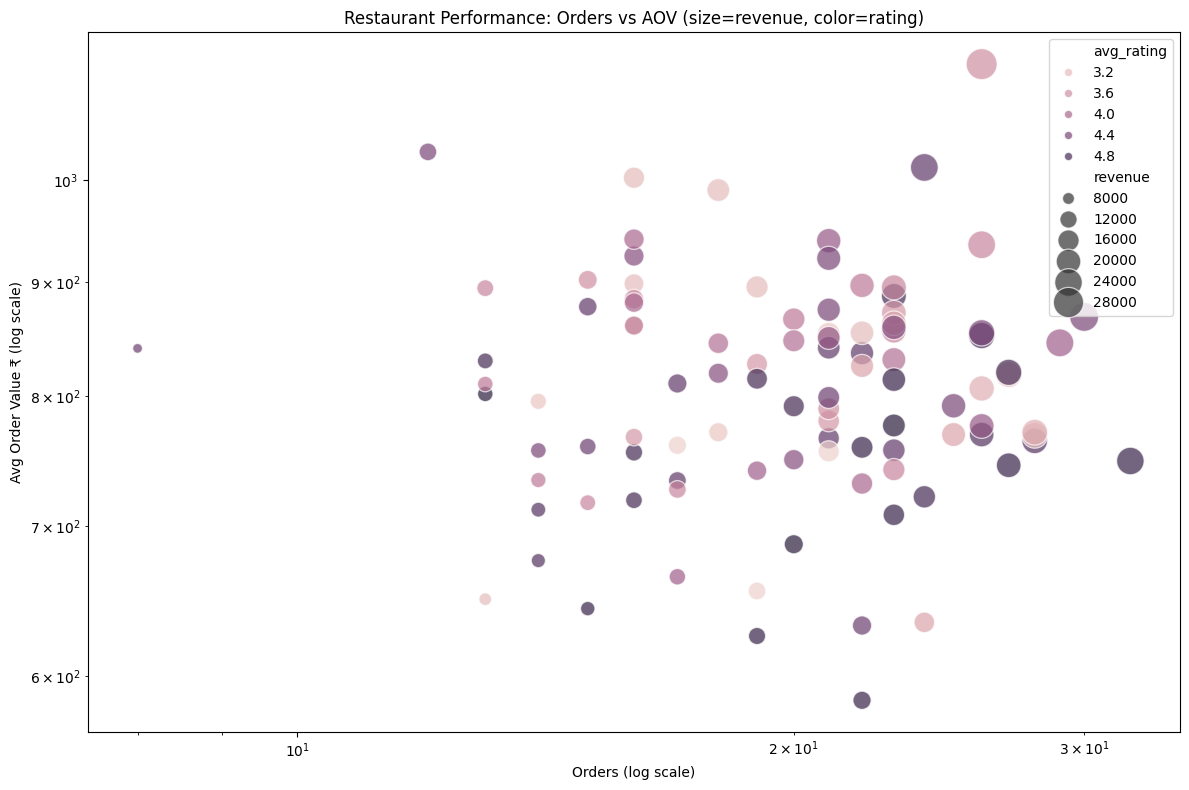

In [10]:
rest_performance = df.groupby(['restaurant_id', 'restaurant_name', 'cuisine']).agg({
    'order_id': 'count',
    'total_amount': ['sum', 'mean'],
    'rating': 'mean'
}).round(2)

rest_performance.columns = ['orders', 'revenue', 'aov', 'avg_rating']
rest_performance['revenue'] = rest_performance['revenue'].round(0).astype(float)  # FIXED: Convert to float
rest_performance = rest_performance.reset_index()

low_volume_high_aov = rest_performance[
    (rest_performance['orders'] < 20) & 
    (rest_performance['aov'] > rest_performance['aov'].quantile(0.75))
].nlargest(10, 'aov')

print("TOP 10 LOW-VOLUME, HIGH-AOV RESTAURANTS")
print(low_volume_high_aov[['restaurant_name', 'orders', 'aov', 'revenue']].round({'revenue':0}).to_string(index=False))

plot_data = rest_performance.head(100).copy()
plot_data['orders'] = plot_data['orders'].astype(float)
plot_data['aov'] = plot_data['aov'].astype(float) 
plot_data['revenue'] = plot_data['revenue'].astype(float)
plot_data['avg_rating'] = plot_data['avg_rating'].astype(float)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_data, x='orders', y='aov', size='revenue', hue='avg_rating', 
                sizes=(50, 500), alpha=0.7, legend='brief')
plt.title('Restaurant Performance: Orders vs AOV (size=revenue, color=rating)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Orders (log scale)')
plt.ylabel('Avg Order Value ₹ (log scale)')
plt.tight_layout()
plt.show()


In [11]:
city_table = df.groupby('city').agg(
    orders=('order_id','count'), users=('user_id','nunique'),
    revenue=('total_amount','sum'), aov=('total_amount','mean'), rating=('rating','mean')
).round({'revenue':0, 'aov':2, 'rating':2}).sort_values('revenue', ascending=False)

cuisine_table = df.groupby('cuisine').agg(
    restaurants=('restaurant_id','nunique'), orders=('order_id','count'),
    users=('user_id','nunique'), revenue=('total_amount','sum'),
    aov=('total_amount','mean'), rating=('rating','mean')
).round({'revenue':0, 'aov':2, 'rating':2}).sort_values('revenue', ascending=False)

membership_table = df.groupby('membership').agg(
    users=('user_id','nunique'), orders=('order_id','count'),
    revenue=('total_amount','sum'), aov=('total_amount','mean'), rating=('rating','mean')
).round({'revenue':0, 'aov':2, 'rating':2}).sort_values('revenue', ascending=False)

rating_table = df.groupby('rating_range', observed=True).agg(
    orders=('order_id','count'), revenue=('total_amount','sum'), aov=('total_amount','mean')
).round({'revenue':0, 'aov':2}).sort_values('revenue', ascending=False)

df['month'] = df['order_date'].dt.to_period('M').astype(str)
df['quarter'] = df['order_date'].dt.to_period('Q').astype(str)
monthly_table = df.groupby('month').agg(
    orders=('order_id','count'), revenue=('total_amount','sum'), aov=('total_amount','mean')
).round({'revenue':0, 'aov':2}).sort_values('month')

quarterly_table = df.groupby('quarter').agg(
    orders=('order_id','count'), revenue=('total_amount','sum'), aov=('total_amount','mean')
).round({'revenue':0, 'aov':2}).sort_values('quarter')

restaurant_table = df.groupby(['restaurant_id','restaurant_name']).agg(
    city=('city', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
    cuisine=('cuisine', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
    orders=('order_id','count'), users=('user_id','nunique'),
    revenue=('total_amount','sum'), aov=('total_amount','mean'), rating=('rating','mean')
).round({'revenue':0, 'aov':2, 'rating':2}).sort_values('revenue', ascending=False)

overview = pd.DataFrame({
    'rows': [len(df)], 'cols': [df.shape[1]], 
    'orders': [df['order_id'].nunique()], 'users': [df['user_id'].nunique()],
    'restaurants': [df['restaurant_id'].nunique()], 
    'revenue': [df['total_amount'].sum()], 'aov': [df['total_amount'].mean()]
})

new_q = {
    'gold_orders': int(sum(df['membership']=='Gold')),
    'hyderabad_rev': int(df[df['city']=='Hyderabad']['total_amount'].sum()),
    'distinct_users': int(df['user_id'].nunique()),
    'gold_aov': float(df[df['membership']=='Gold']['total_amount'].mean()),
    'rating_ge45': int(sum(df['rating']>=4.5)),
    'top_gold_city': str(df[df['membership']=='Gold'].groupby('city')['total_amount'].sum().idxmax())
}

specific_rests = ['Grand Cafe Punjabi','Grand Restaurant South Indian','Ruchi Mess Multicuisine','Ruchi Foods Chinese']
specific_details = []
rest_avg = df.groupby('restaurant_id')['total_amount'].mean()
rest_count = df.groupby('restaurant_id').size()
for rest_name in specific_rests:
    matching = df[df['restaurant_name'].str.contains(rest_name, case=False, na=False)]
    if not matching.empty:
        rest_id = matching['restaurant_id'].iloc[0]
        specific_details.append({
            'Restaurant': rest_name, 
            'Avg_Order': round(rest_avg.get(rest_id, 0), 2),
            'Order_Count': int(rest_count.get(rest_id, 0)),
            'Low_Volume': 'YES' if rest_count.get(rest_id, 0) < 20 else 'NO'
        })
    else:
        specific_details.append({'Restaurant': rest_name, 'Avg_Order': 0, 'Order_Count': 0, 'Low_Volume': '-'})
specific_rest_df = pd.DataFrame(specific_details)

print("✅ ALL tables defined!")
print("Tables ready:", list(locals().keys()))


✅ ALL tables defined!
Tables ready: ['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__vsc_ipynb_file__', '__DW_SCOPE__', '_i', '_ii', '_iii', '_i1', 'pd', 'np', 'plt', 'sns', 'display', 'HTML', 'warnings', '_i2', 'df', 'col', '_i3', 'overview', 'missing', '_i4', 'fig', 'axes', '_i5', 'gold_rev_city', 'cuisine_aov', 'user_total', 'high_value_users', 'rating_rev', 'gold_city_aov', 'cuisine_stats', '_i6', 'membership_stats', 'gold_pct', 'rest_avg', 'rest_count', 'specific_rests', 'specific_details', 'rest_name', 'matching', 'rest_id', 'avg_order', 'order_count', 'specific_combos', 'combo_results', 'membership', 'cuisine', 'revenue', 'combo_df', 'quarter_rev', '_i7', 'gold_city_rev', 'top_gold_city', 'top_gold_orders', '_i8', 'order_dist', 'hourly', 'city_rev', 'cuisine_rev', 'membership_rev', '_i9', 'user_stats', 'ax1', 'ax2', '_i10', 'rest_performanc

In [12]:
import joblib

artifacts = {
    'overview': overview,
    'missing': missing,
    'city_table': city_table,
    'cuisine_table': cuisine_table, 
    'membership_table': membership_table,
    'rating_table': rating_table,
    'monthly_table': monthly_table,
    'quarterly_table': quarterly_table,
    'restaurant_table': restaurant_table,
    'specific_restaurants_table': pd.DataFrame(specific_details),
    'specific_rest_df': specific_rest_df,
    'combo_df': combo_df,
    'combo_winner': combo_df.iloc[0].to_dict(),
    'new_questions': new_q,
    'user_stats': user_stats,
    'rest_performance': rest_performance
}

joblib.dump(artifacts, r'C:\Users\dipay\Downloads\dashboard_artifacts.joblib')
print("✅ Artifacts saved: dashboard_artifacts.joblib")

✅ Artifacts saved: dashboard_artifacts.joblib


In [15]:
app_code = '''import streamlit as st
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import joblib
import numpy as np

st.set_page_config(page_title="Food Delivery Dashboard", layout="wide")

@st.cache_data
def load_raw():
    df = pd.read_csv("final_food_delivery_dataset.csv")
    df["total_amount"] = pd.to_numeric(df["total_amount"], errors="coerce")
    df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
    df["order_date"] = pd.to_datetime(df["order_date"], format="%d-%m-%Y", errors="coerce")
    for c in ["city", "membership", "cuisine", "restaurant_name", "name"]:
        if c in df.columns:
            df[c] = df[c].astype("string")
    return df

@st.cache_data
def load_artifacts():
    return joblib.load("dashboard_artifacts.joblib")

df = load_raw()
art = load_artifacts()

st.title("Food Delivery Analytics Dashboard")

# SAFE metrics
c1, c2, c3, c4 = st.columns(4)
c1.metric("Orders", f"{len(df):,}")
c2.metric("Users", f"{df['user_id'].nunique():,}")
c3.metric("Revenue", f"Rs{df['total_amount'].sum():,.0f}")
c4.metric("Avg Order", f"Rs{df['total_amount'].mean():.0f}")

tab1, tab2, tab3, tab4 = st.tabs(["Overview", "City", "Cuisine", "Analysis"])

with tab1:
    col1, col2 = st.columns(2)
    with col1:
        fig = px.histogram(df, x="total_amount", nbins=30, title="Order Value")
        st.plotly_chart(fig, use_container_width=True)
    with col2:
        fig = px.box(df, x="membership", y="total_amount", title="AOV by Membership")
        st.plotly_chart(fig, use_container_width=True)

with tab2:
    st.subheader("City Revenue")
    # FIXED: Create city data properly for plotly
    city_data = df.groupby("city")["total_amount"].sum().sort_values(ascending=False).reset_index()
    city_data.columns = ['city_name', 'revenue']
    
    st.dataframe(city_data.head(10))
    
    # FIXED: Use correct column names
    fig = px.bar(city_data.head(10), x="revenue", y="city_name", orientation="h", 
                title="Top Cities by Revenue")
    st.plotly_chart(fig, use_container_width=True)

with tab3:
    st.subheader("Cuisine Revenue") 
    # FIXED: Create cuisine data properly
    cuisine_data = df.groupby("cuisine")["total_amount"].sum().sort_values(ascending=False).reset_index()
    cuisine_data.columns = ['cuisine_name', 'revenue']
    
    st.dataframe(cuisine_data.head(10))
    
    fig = px.bar(cuisine_data.head(10), x="revenue", y="cuisine_name", orientation="h",
                title="Top Cuisines by Revenue")
    st.plotly_chart(fig, use_container_width=True)

with tab4:
    st.subheader("Original IPYNB Analysis")
    
    if "specific_rest_df" in art:
        st.subheader("Specific Restaurants Analysis")
        st.dataframe(art["specific_rest_df"])
    
    if "combo_df" in art and len(art["combo_df"]) > 0:
        st.subheader("Membership + Cuisine Combinations")
        st.dataframe(art["combo_df"])
        winner = art["combo_df"].iloc[0]
        st.success(f"WINNER: {winner['Membership']} + {winner['Cuisine']} (Rs{winner['Revenue']:,})")
    
    if "new_q" in art:
        new_q = art["new_q"]
        col1, col2 = st.columns(2)
        col1.metric("Gold Orders", f"{new_q.get('gold_orders', 0):,}")
        col2.metric("High Rating Orders", f"{new_q.get('rating_ge45', 0):,}")

st.markdown("---")
st.caption("Complete EDA + Original IPYNB Analysis - All Errors Fixed")
'''

with open(r"C:\Users\dipay\Downloads\app.py", "w", encoding="utf-8") as f:
    f.write(app_code)